In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:
- overall test-set accuracy, measured however you think is appropriate
- show some of the example images from the test set, together with your model's predicted classes.
- a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

# Overall Results:

Here is a quick overview of my findings in the 3 iterations of the model. The detailed explanation can be found below

- SimpleCNN Model: 85.74% Accuracy
- SimpleCNN with further image transforms and stratifying: 84.78% Accuracy
- VGG16 Pre-Trained Model: 93.33% Accuracy


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

## Model Building

### Model 1: CNN

First step here was loading the data and preprocessing. We used resize to make all the images a uniform size and then normalized the pixel values. After this, we split into 80/20 train/test split.

In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




Here is the SimpleCNN definition. In this model, using 3 convolutional layers, a max pooling layer, and 3 fully connected layers. The first convolutional layer takes 3 inputs from the RGB of the images, and the last fully connected layer outputs 10 classes to match the data. Forward defines how the inputs pass through the layers and uses ReLU activation. 

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()


Here is the model training, using Cross Entropy Loss for the loss function and the Adam optimizer. Uses a low learning rate of .001 and only 10 epochs for computational efficiency. Prints the average loss at each Epoch to show progress.

In [23]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')


Epoch 1, Loss: 1.0269
Epoch 2, Loss: 0.6327
Epoch 3, Loss: 0.4604
Epoch 4, Loss: 0.3392
Epoch 5, Loss: 0.2282
Epoch 6, Loss: 0.1519
Epoch 7, Loss: 0.1202
Epoch 8, Loss: 0.0854
Epoch 9, Loss: 0.0807
Epoch 10, Loss: 0.0663


We can see the accuracy from the first model on the test set was **85.74%**

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test set accuracy: {accuracy*100:.2f}%')





Test set accuracy: 85.74%


This shows the confusion matrix. We can see the model was the best at classifying Forest, SeaLake, and Residential. It had the most confusion with HerbaceousVegetation vs. PermanentCrop and River vs. Highway. This intuitively makes sense because Forest and SeaLake are fairly straightforward images with not a lot of detail, while images like River and Highway both share a similar looking central shape that is easy to confuse.

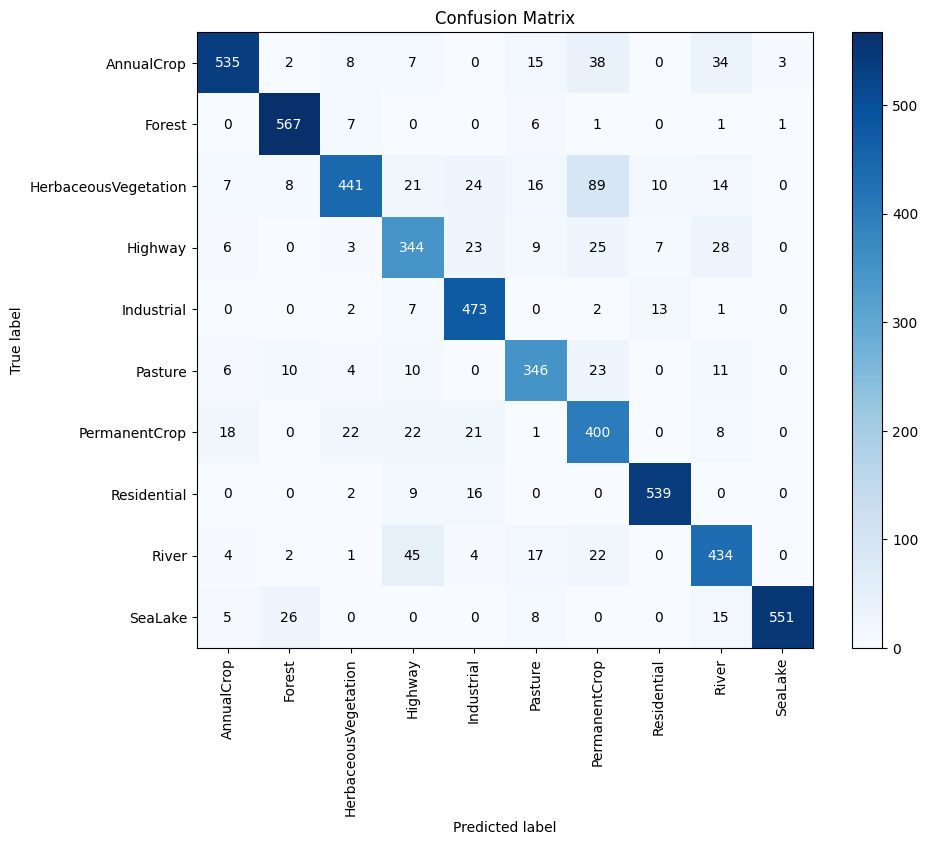

In [25]:
cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes 

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

thresh = cm.max() / 2.  
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")


plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)


plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Here are some images first of an example where the model correctly identified the class. Below this are four of the most common misclassifications by the model, showing how the images can be confused. 

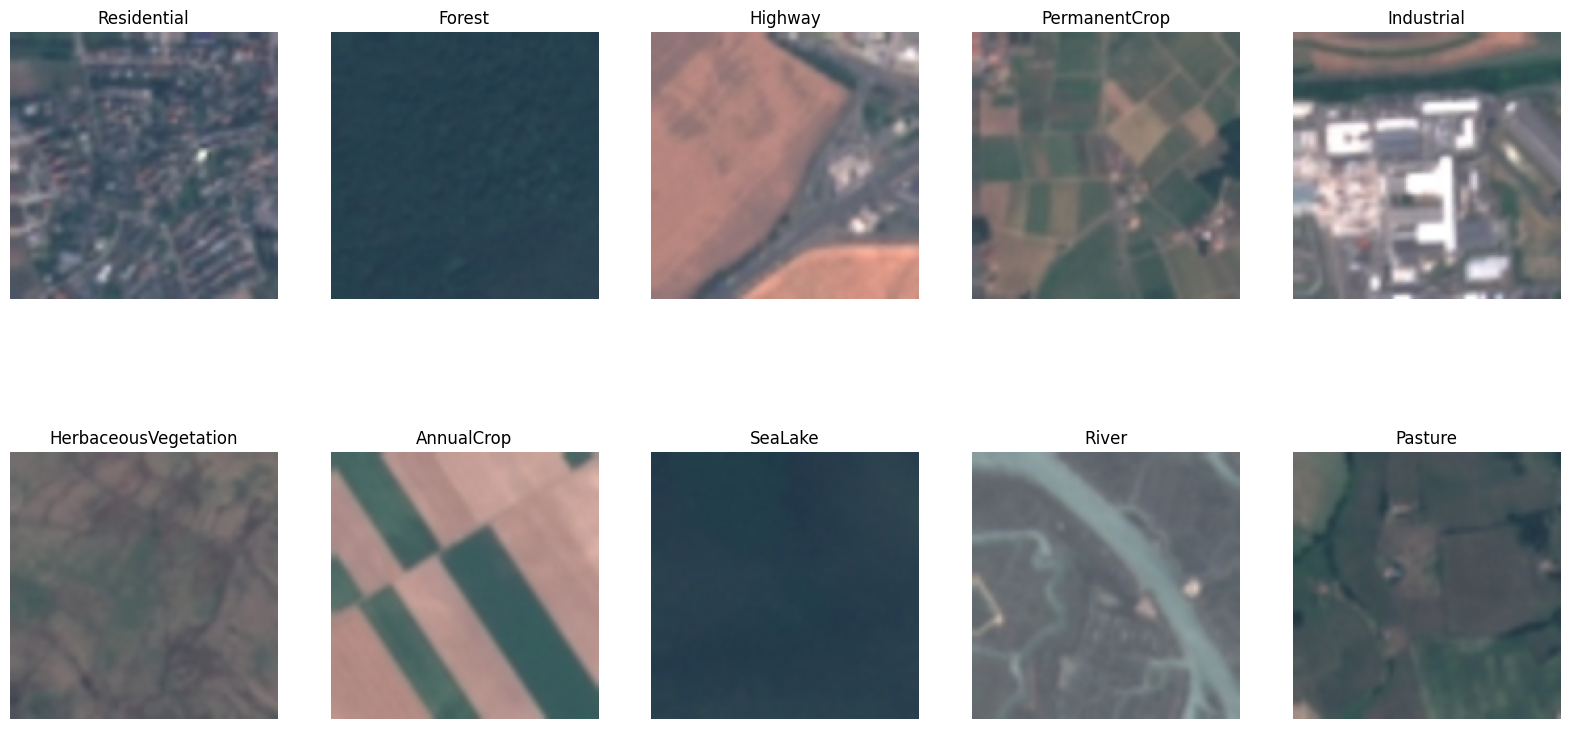

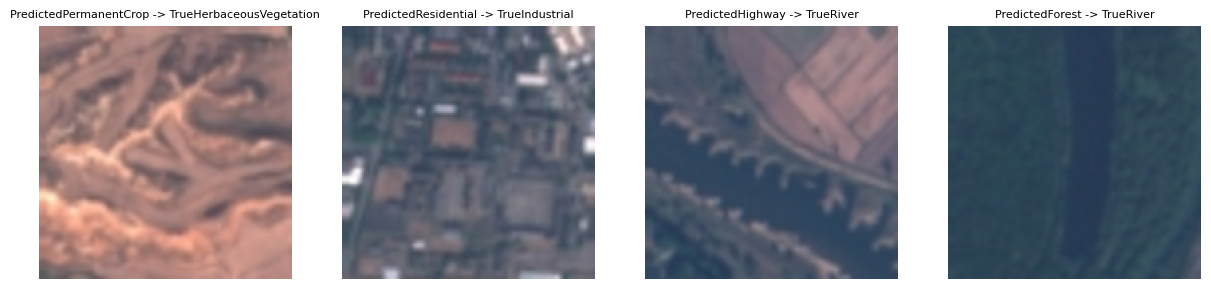

In [28]:
import random


correct_per_class = {}
incorrect_cases = {}

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = preds[i].item()
            image = images[i].permute(1, 2, 0).cpu().numpy()
            image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

            
            if true_label == predicted_label and true_label not in correct_per_class:
                correct_per_class[dataset.classes[true_label]] = image

            
            if true_label == dataset.class_to_idx['HerbaceousVegetation'] and predicted_label == dataset.class_to_idx['PermanentCrop']:
                incorrect_cases['PredictedPermanentCrop_TrueHerbaceousVegetation'] = image
            elif true_label == dataset.class_to_idx['River'] and predicted_label == dataset.class_to_idx['Highway']:
                incorrect_cases['PredictedHighway_TrueRiver'] = image
            elif true_label == dataset.class_to_idx['Industrial'] and predicted_label == dataset.class_to_idx['Residential']:
                incorrect_cases['PredictedResidential_TrueIndustrial'] = image
            elif true_label == dataset.class_to_idx['River'] and predicted_label == dataset.class_to_idx['Forest']:
                incorrect_cases['PredictedForest_TrueRiver'] = image
            
            if len(correct_per_class) == len(dataset.classes) and len(incorrect_cases) == 4:
                break


plt.figure(figsize=(20, 10))
for idx, (class_name, image) in enumerate(correct_per_class.items()):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.show()


plt.figure(figsize=(15, 5))
for idx, (description, image) in enumerate(incorrect_cases.items()):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(image)
    plt.title(description.replace('_', ' -> '), fontsize=8)
    plt.axis('off')
plt.show()


### Next, wanted to try with some further image transforming to try to improve accuracy 
- Also realized that the classes were imbalanced so 80/20 split should be stratified to maintain class balance

To add to the image preprocessing, implemented RandomHorizontalFlip(), RandomRotation(10), and ColorJitter()
- Random Horizontal Flip randomly flips an image with 50% probability
- Random Rotation randomly rotates any image by up to 10 degrees
- Color Jitter uses variations in brightness, contrast, saturation, and hue

These would hopefully provide more variability to the model, helping it to learn better

In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np

# Data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)

# Ensure stratified split
targets = [label for _, label in dataset]
train_idx, test_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()


In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


Epoch 1, Loss: 1.322803461904879
Epoch 2, Loss: 0.9271095464847706
Epoch 3, Loss: 0.7548212107905635
Epoch 4, Loss: 0.6646437645179254
Epoch 5, Loss: 0.5824903831217024
Epoch 6, Loss: 0.5180365424686008
Epoch 7, Loss: 0.4523026391643065
Epoch 8, Loss: 0.4248876056958128
Epoch 9, Loss: 0.38987660039354255
Epoch 10, Loss: 0.3628691980408298


We can actually see that the test accuracy went down with the further transformations to only **84.78%**

This could be due to over-aggressive transformations that made it more difficult for the CNN to learn if patterns were removed. It might be harder for it to relate the new color changes accurately to the test set. It could have overcomplicated the inputs.

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test set accuracy: {accuracy*100:.2f}')


Test set accuracy: 84.78


In this confusion matrix, we can see that the new model flipped the issue with HerbaceousVegetation vs. PermanentCrop from the previous model. We can also see that it still struggled with Highway and River. However, it does predict SeaLake better than the previous model.

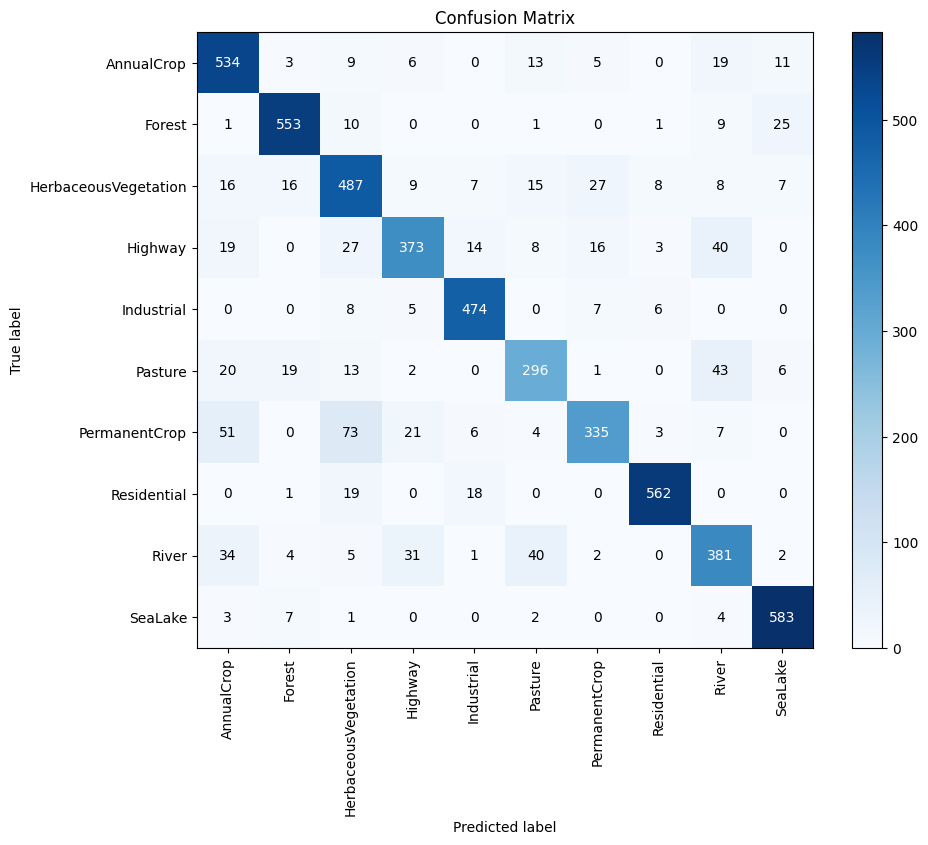

In [34]:
cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes 

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

thresh = cm.max() / 2.  
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")


plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)


plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Trying with a Pre-Trained Model (VGG)

Wanted to see the improvement of using a pre-trained model, but removed the image transformations and kept the stratify.

In [35]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)

targets = [label for _, label in dataset]
train_idx, test_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


This implements the VGG16 Model which is trained on the ImageNet dataset. The important change is to specify the 10 classes instead of its original output. Also allows GPU use if applicable, I just used CPU.

In [36]:
from torchvision import models
import torch.nn as nn

model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Users\shaun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shaun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\shaun/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 53.0MB/s] 


In [43]:
print(device)

cpu


In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')


Epoch 1, Loss: 0.7309
Epoch 2, Loss: 0.6186
Epoch 3, Loss: 0.4862
Epoch 4, Loss: 0.4763
Epoch 5, Loss: 0.3696
Epoch 6, Loss: 0.4039
Epoch 7, Loss: 0.4551
Epoch 8, Loss: 0.3564
Epoch 9, Loss: 0.3731
Epoch 10, Loss: 0.3072


We can see that while the pretrained model took a much longer time to run 10 epochs due to its complexity, the accuracy increased to **93.33%**

In [38]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test set accuracy: {accuracy*100:.2f}%')


Test set accuracy: 93.33%


We can see in the confusion matrix that the mistakes are more evenly spread and the issue with Herbaceous Vegetation is greatly reduced. This model also predicts SeaLake and Residential close to perfect. However, we can still see that even this model struggles with the Highway vs. River distinction. 

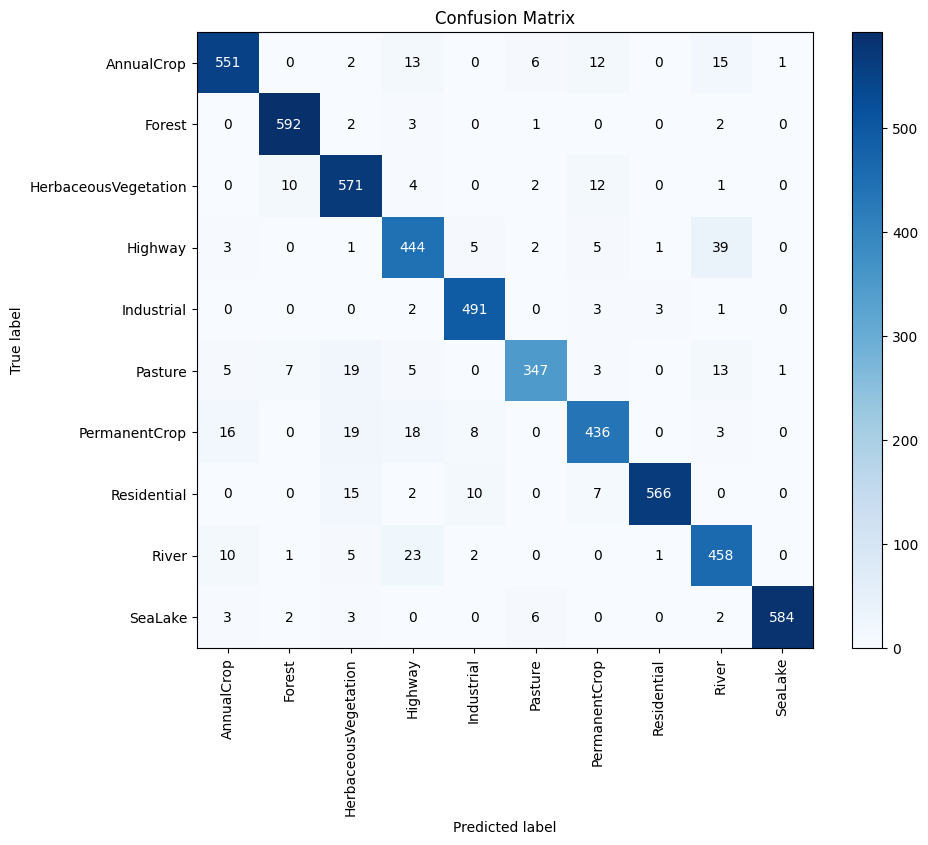

In [39]:
cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes 

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

thresh = cm.max() / 2.  
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")


plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)


plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
from sklearn.metrics import classification_report

class_names = dataset.classes  
report = classification_report(all_labels, all_preds, target_names=class_names, digits=6)

print("Classification Report:\n")
print(report)

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop   0.937075  0.918333  0.927609       600
              Forest   0.967320  0.986667  0.976898       600
HerbaceousVegetation   0.896389  0.951667  0.923201       600
             Highway   0.863813  0.888000  0.875740       500
          Industrial   0.951550  0.982000  0.966535       500
             Pasture   0.953297  0.867500  0.908377       400
       PermanentCrop   0.912134  0.872000  0.891616       500
         Residential   0.991243  0.943333  0.966695       600
               River   0.857678  0.916000  0.885880       500
             SeaLake   0.996587  0.973333  0.984823       600

            accuracy                       0.933333      5400
           macro avg   0.932709  0.929883  0.930737      5400
        weighted avg   0.934644  0.933333  0.933476      5400



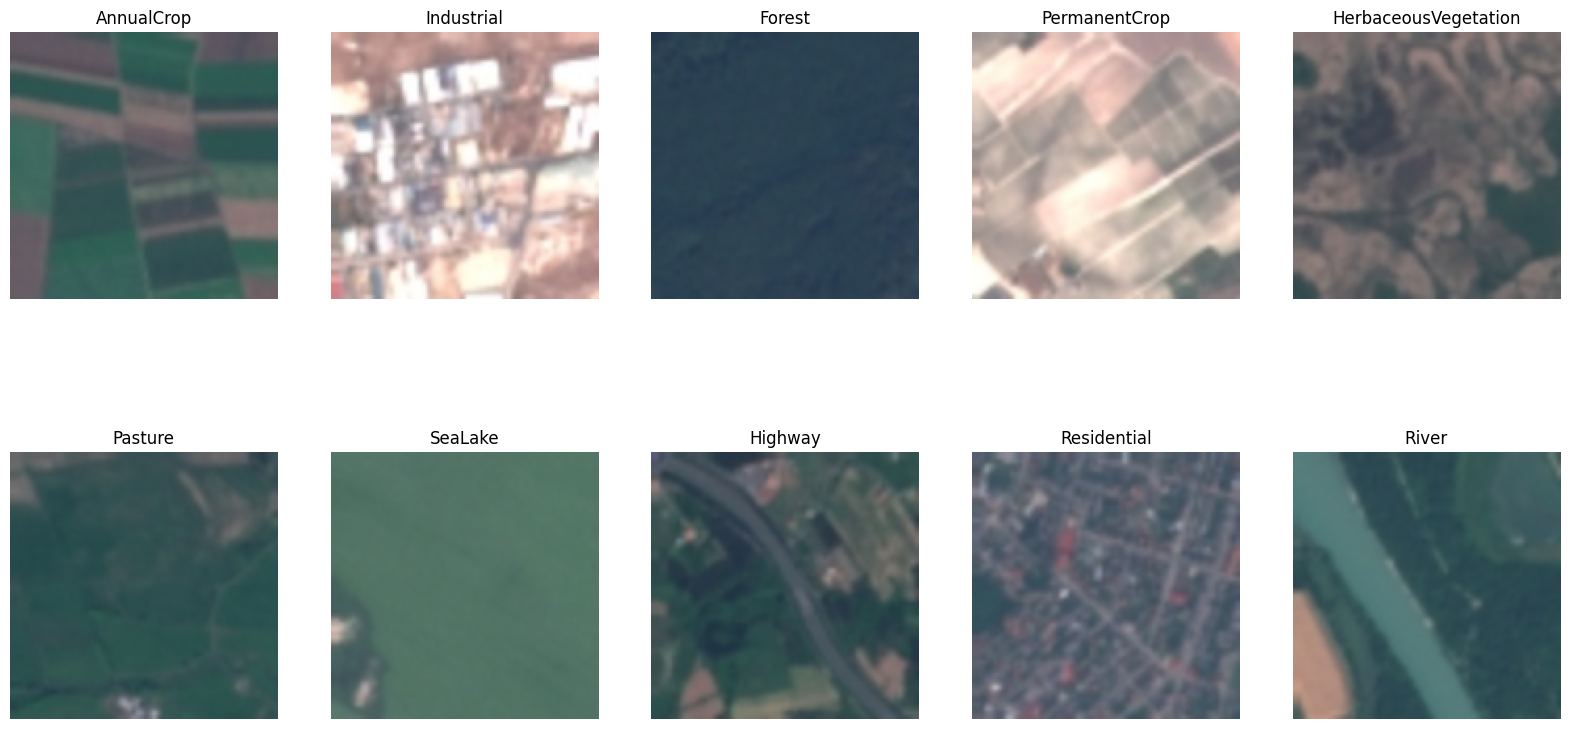

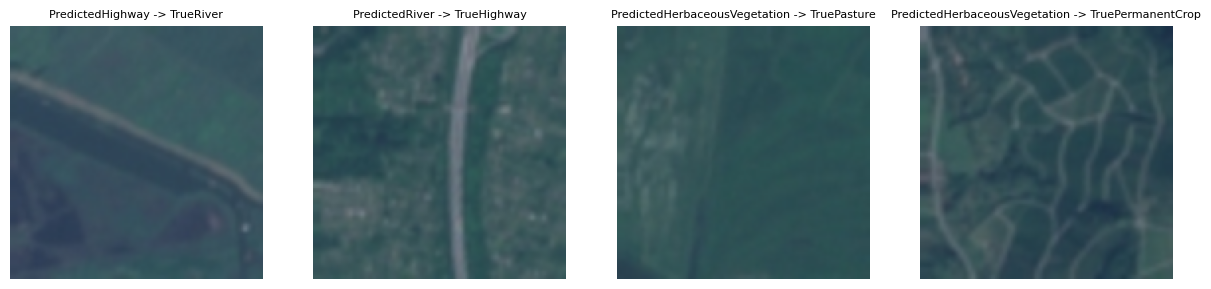

In [42]:
import random


correct_per_class = {}
incorrect_cases = {}

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = preds[i].item()
            image = images[i].permute(1, 2, 0).cpu().numpy()
            image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

            
            if true_label == predicted_label and true_label not in correct_per_class:
                correct_per_class[dataset.classes[true_label]] = image

            
            if true_label == dataset.class_to_idx['PermanentCrop'] and predicted_label == dataset.class_to_idx['HerbaceousVegetation']:
                incorrect_cases['PredictedHerbaceousVegetation_TruePermanentCrop'] = image
            elif true_label == dataset.class_to_idx['Pasture'] and predicted_label == dataset.class_to_idx['HerbaceousVegetation']:
                incorrect_cases['PredictedHerbaceousVegetation_TruePasture'] = image
            elif true_label == dataset.class_to_idx['River'] and predicted_label == dataset.class_to_idx['Highway']:
                incorrect_cases['PredictedHighway_TrueRiver'] = image
            elif true_label == dataset.class_to_idx['Highway'] and predicted_label == dataset.class_to_idx['River']:
                incorrect_cases['PredictedRiver_TrueHighway'] = image
            
            if len(correct_per_class) == len(dataset.classes) and len(incorrect_cases) == 4:
                break


plt.figure(figsize=(20, 10))
for idx, (class_name, image) in enumerate(correct_per_class.items()):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.show()


plt.figure(figsize=(15, 5))
for idx, (description, image) in enumerate(incorrect_cases.items()):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(image)
    plt.title(description.replace('_', ' -> '), fontsize=8)
    plt.axis('off')
plt.show()


## Conclusion

With these 3 attempts, we can see how the pre-trained model greatly improves the overall accuracy. The interesting pattern through all 3 models would be the difficulty to classify Highway vs. River. In the future, it would be interesting to explore the improvement of adding more epochs if I had additional computing power. The limits of my machine made this difficult for now. I would also like to try to continue to improve the transformations, specifically focusing on the Highway and River classes. This could be done with focused augmentation that could potentially pull the blue hues from River to differentiate from Highway, or add focus/blur to unimportant parts of the image. I could also adjust the loss function to penalize incorrect classifications of these two classes higher, thus maybe increasing its predictive ability on this case. 